In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import gym

# import wandb

LR = 0.0001
HIDDEN_SZ = 128
BATCH_SZ = 1

actor_l, critic_l = [], []
test_rew = []

In [223]:
class Actor(nn.Module):
    def __init__(self, inp_sz, hidden_sz, act_sz):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(inp_sz, hidden_sz)
        self.fc2 = nn.Linear(hidden_sz, hidden_sz)
        self.fc3 = nn.Linear(hidden_sz, act_sz)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)

        out = [0.00001] 
        out = torch.tensor(out, dtype=torch.float32, requires_grad=True)
        # print('out: ', out)


        return out
    
    def act(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

# wandb.init( project="A2C", config={"lr": LR, "hidden_size": 16, "batch_size": 32, "max_episodes": 501} )

In [224]:
class Critic(nn.Module): # or Value function

    def __init__(self, inp_sz, hidden_sz, out_sz):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(inp_sz, hidden_sz)
        self.fc2 = nn.Linear(hidden_sz, hidden_sz)
        self.fc3 = nn.Linear(hidden_sz, out_sz)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

In [225]:
class A2C:
    def __init__(self):
        self.env = gym.make('CartPole-v0')
    
        self.critic = Critic(self.env.observation_space.shape[0], HIDDEN_SZ, 1)
        self.actor = Actor(self.env.observation_space.shape[0], HIDDEN_SZ, self.env.action_space.n)

        self.critic_optim = optim.Adam(self.critic.parameters(), lr=LR)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=LR)
    
    def test(self):
        env = self.env
        obs = env.reset()[0]
        obs = torch.tensor(obs, dtype=torch.float)
        rew_ep = 0
        done = False

        while not done:
            # policy = self.actor(obs)
            # policy = self.actor(obs.detach().numpy())
            # act = torch.multinomial(policy, 1).detach().numpy()
            act = self.actor.act(obs)
            obs, rew, done, _, _ = env.step(int(act))
            rew_ep += rew

            obs = torch.tensor(obs, dtype=torch.float)
            # print('test: ', type(policy))

        env.close()
        return rew_ep

    
    def train(self, epochs, batch_sz):

        episode = 0
        actions = np.empty((batch_sz,), dtype=int)
        dones = np.empty((batch_sz,), dtype=bool)
        rewards, values = np.empty((2, batch_sz), dtype=np.float64)
        states = np.empty((batch_sz,) + self.env.observation_space.shape, dtype=np.float64)
        obs = self.env.reset()[0]
        # test_rew = []

        for epoch in range(epochs):
            for i in range(batch_sz):
                states[i] = obs
                values[i] = self.critic(torch.from_numpy(states[i]).float())
                # policy = self.actor(torch.from_numpy(states[i]).float())
                # print('train :', type(policy))
                # actions[i] = torch.multinomial(policy, 1).detach().numpy()
                actions[i] = self.actor.act(torch.from_numpy(states[i]).float())
                obs, rewards[i], dones[i], _, _ = self.env.step(actions[i])

                if dones[i]:
                    obs = self.env.reset()[0]

            if dones[-1]:
                next_val = 0
            else:
                next_val = self.critic(torch.from_numpy(obs).float()).detach().numpy()[0]
            
            episode += sum(dones)

            returns = np.append(np.zeros_like(rewards), [next_val], axis=0)
            print('rewards: ', rewards)

            for i in reversed(range(rewards.shape[0])):
                returns[i] = rewards[i] + 0.99 * returns[i+1]
            returns = returns[:-1]
            advantages = returns - values
            # print('returns: ', returns)
            print('advantages: ', advantages)

            # beginning of optimising the model
            acts = F.one_hot(torch.tensor(actions), self.env.action_space.n)
            ret = torch.tensor(returns[:,None], dtype=torch.float)
            adv = torch.tensor(advantages, dtype=torch.float)
            obser = torch.tensor(states, dtype=torch.float)

            # MSE for the values
            # Actor and entropy loss

            self.actor_optim.zero_grad()
            self.critic_optim.zero_grad()

            # print(self.critic(obser))

            critic_loss = 0.5 * F.mse_loss(self.critic(obser), ret)

            gradient = acts - self.actor(obser)
            gradient = gradient.transpose(0,1)
            grad_with_adv = 0.0001 * gradient * adv 
            grad_with_adv = grad_with_adv.transpose(0,1)
            grad_with_adv += self.actor(obser)
            grad_with_adv = grad_with_adv.transpose(0,1)
            actor_loss = -torch.mean(torch.log(grad_with_adv) * adv.detach())

            # critic_loss = F.mse_loss(self.critic(obser), ret)
            # actor_loss = -torch.mean(torch.log(self.actor(obser)).reshape(-1,1) * adv.detach())
            entropy_loss = -torch.mean(torch.log(self.actor(obser)) * self.actor(obser))
            # critic_loss += 0.01 * entropy_loss
            actor_loss += 0.001 * entropy_loss

            actor_l.append(actor_loss)
            critic_l.append(critic_loss)

            actor_loss.backward()
            critic_loss.backward()

            self.actor_optim.step()
            self.critic_optim.step()
            
            if epoch % 50 == 0:
                # print("epoch: ", epoch)
                # test_rew.append([np.array(self.test() for _ in range(50))])
                tmp = []
                for _ in range(50):
                    trew = self.test()
                    # print(trew, end=' ')
                    tmp.append(trew)
                test_rew.append(tmp)    
                print(f"Epoch: {epoch}, Mean Reward: {np.mean(test_rew[-1])}, std: {np.std(test_rew[-1])}")

                # early stopping
                if np.mean(test_rew[-1]) > 195:
                    print("Early stopping")
                    break
                
                obs = self.env.reset()[0]
            
        print(f'training done {epoch} epochs')

In [226]:
agent = A2C()
rewards = agent.train(401, BATCH_SZ)

# wandb.finish()

/home/mekasaimukund/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


rewards:  [1.]
advantages:  [0.97672779]
Epoch: 0, Mean Reward: 9.34, std: 0.6814690014960328
rewards:  [1.]
advantages:  [0.97656979]
rewards:  [1.]
advantages:  [0.98540399]
rewards:  [1.]
advantages:  [0.9827985]
rewards:  [1.]
advantages:  [0.98579264]
rewards:  [1.]
advantages:  [0.98886214]
rewards:  [1.]
advantages:  [0.9936458]
rewards:  [1.]
advantages:  [0.99066279]
rewards:  [1.]
advantages:  [0.99103073]
rewards:  [1.]
advantages:  [0.95547517]
rewards:  [1.]
advantages:  [0.98272101]
rewards:  [1.]
advantages:  [0.99216022]
rewards:  [1.]
advantages:  [0.99430447]
rewards:  [1.]
advantages:  [0.99514011]
rewards:  [1.]
advantages:  [1.00346509]
rewards:  [1.]
advantages:  [1.00459619]
rewards:  [1.]
advantages:  [1.00586979]
rewards:  [1.]
advantages:  [0.83507523]
rewards:  [1.]
advantages:  [0.98867182]
rewards:  [1.]
advantages:  [0.99575234]
rewards:  [1.]
advantages:  [1.00537161]
rewards:  [1.]
advantages:  [1.00259256]
rewards:  [1.]
advantages:  [1.01186398]
reward

In [227]:
actor_l = [ i.cpu().detach().numpy() for i in actor_l ]
critic_l = [ i.cpu().detach().numpy() for i in critic_l ]

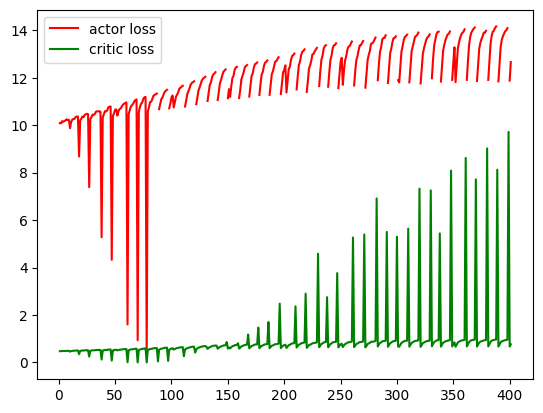

In [228]:
epis = [ i + 1 for i in range(len(actor_l)) ]
# epis = np.array(epis)

# print(actor_l, critic_l)

plt.plot(epis, actor_l, label='actor loss', color='red')
plt.plot(epis, critic_l, label='critic loss', color='green')

plt.legend()
plt.show()

In [229]:
while len(actor_l) % 50 != 0:    
    actor_l.pop() 
    critic_l.pop()

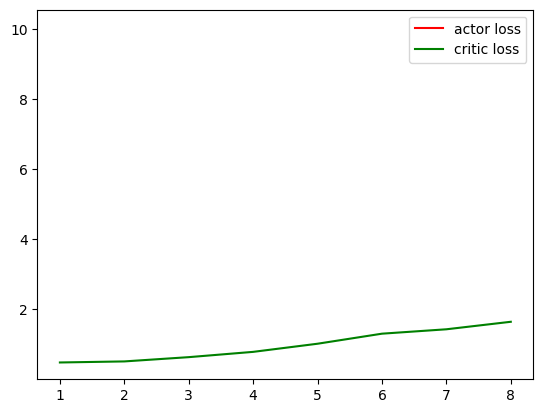

In [230]:
# average loss for every 50 episodes
# avg_actor_l = np.array(actor_l).resize(500)

avg_actor_l = np.array(actor_l).reshape(-1, 50).mean(axis=1)
avg_critic_l = np.array(critic_l).reshape(-1, 50).mean(axis=1)
epis = [ i + 1 for i in range(len(avg_actor_l)) ]

plt.plot(epis, avg_actor_l, label='actor loss', color='red')
plt.plot(epis, avg_critic_l, label='critic loss', color='green')

plt.legend()
plt.show()


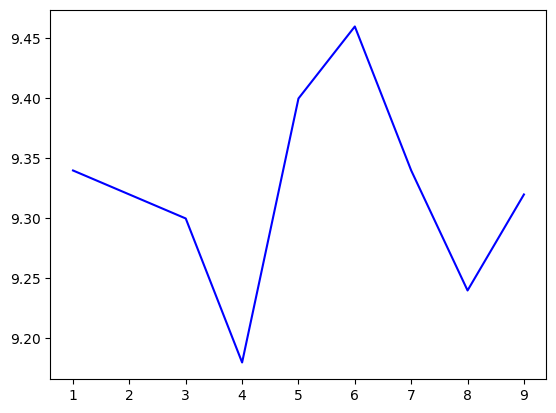

In [231]:
epis = [ i + 1 for i in range(len(test_rew)) ]
mean_test_rew = [ np.mean(i) for i in test_rew ]
plt.plot(epis, mean_test_rew, label='test reward', color='blue')

plt.show()